SMB、HML两个指标的计算方式如下：
1. 首先，按市值大小平均分为两组(Small 组, Big 组)，基准是这一时间的市场上公司市值中位数;
2. 按 BM 从小到大分三组,即前 30%(Growth 组),中间 40%(Neutral 组),后 30%(Value 组)；
3. 每个组的月回报以组内所有成员股票当月回报的加权平均数为依据,计算每个月的 SMB 和 HML 值。具体计算公式如下: 
   SMB = Small size return - Big size return)
   HML = Value company return - Growth company return
4. 以市场回报减去无风险回报,即得到超额市场回报(Rm-Rf)。（由于Ricequant平台无法提取国债收益率，我只能对这个时段的所有IBO1M求平均值作为无风    险回报率

# %pdb

# %load fama.py

In [377]:
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

In [378]:
research_starttime='2010-04-01'
research_endtime='2018-04-01'
format='%Y-%m-%d %H:%M:%S'
data_type=""#"net"
data_mode=""#"fast"
data_mode_global=data_mode

### 定义基础数据获取函数

In [379]:
## 从网络获取数据
#market_cap 指定证券收盘价 x 总股本 x 交易币种兑人民币汇率
def get_dp():
        interval_month=24
        # date_range=pd.date_range(research_starttime,research_endtime)
        # len(date_range)/31
        # pd.to_datetime(research_endtime)-(pd.to_datetime(research_endtime)-pd.to_datetime(research_starttime))/4
        # print(datetime.date.today() +relativedelta(months=-1))
        step0=pd.to_datetime(research_endtime)
        step1=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*1)
        step2=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*2)
        step3=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*3)
        step4=pd.to_datetime(research_endtime)-relativedelta(months=interval_month*4)
        
        #网络请求API
        def get_years_fundamentals(interval_month,enddate):
            return get_fundamentals(
                query(fundamentals.eod_derivative_indicator.market_cap,fundamentals.financial_indicator.book_value_per_share)
                ,enddate, str(interval_month)+'m')
        
        # arr data
        dp_arr = [get_years_fundamentals(interval_month,step0),
                  get_years_fundamentals(interval_month,step1),
                  get_years_fundamentals(interval_month,step2),
                  get_years_fundamentals(interval_month,step3)]
        dp_arr
        
        # merge data 
        dp_merge=pd.concat(dp_arr,axis=1)#,ignore_index=True
        return dp_merge
        
#转换索引
def trans_index(df):
    if(type(df.index[0])==str):
        df.index=pd.to_datetime(df.index)
    return df
        
#get_all_instruments
def all_instruments_cs():
    df_market=None
    if(data_type=="net"):
        df_market = all_instruments(type='CS')
    else:
        df_market=pd.read_csv("all_instruments.csv",index_col=0)
    return df_market

#get_price_cs
def get_price_cs(data_starttime,data_endtime):
    df_price_data=None
    df_market=all_instruments_cs()
    if(data_type=="net"):
        df_price_data = get_price(list(df_market['order_book_id']),start_date=data_starttime, end_date=data_endtime,frequency='1d',fields='close')
    else:
        df_price_data=pd.read_csv("price_data.csv",index_col=0)
        df_price_data=trans_index(df_price_data)
    return df_price_data

#转换Series
def trans_series(df,key=1):
    if(type(df)==pd.DataFrame):
        df=df[key]
    return df


In [380]:
df_book_value=None
df_market_cap=None

#网络获取方式
if(data_type=="net"):
    dp_merge=get_dp()
    df_book_value=dp_merge["book_value_per_share"]
    df_market_cap=dp_merge["market_cap"]
else:
#本地获取方式
    df_book_value=pd.read_csv("./book_value_per_share.csv",index_col=0)
    df_market_cap=pd.read_csv("./market_cap.csv",index_col=0)
    df_book_value=trans_index(df_book_value)
    df_market_cap=trans_index(df_market_cap)

In [381]:
df_book_value

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2018-03-30,11.77,12.0200,1.3740,1.1962,4.1242,1.0991,2.2153,2.1635,2.7179,4.9023,...,3.7975,8.2268,5.8856,5.0689,5.9552,1.7665,4.7320,2.6177,2.3195,2.8958
2018-02-28,11.54,10.5418,1.3740,1.1962,3.7787,1.0991,2.2153,2.1635,2.7179,4.8304,...,3.7975,8.2268,5.8856,5.0689,5.9552,1.7259,4.7320,2.6177,2.3195,2.8958
2018-01-26,11.54,10.5418,1.3740,1.1962,3.7787,1.0991,2.2153,2.1635,2.7179,4.8304,...,3.7975,8.2268,5.8856,5.0689,5.9552,1.7259,4.7320,2.6177,2.3195,2.8958
2017-12-26,11.54,10.5418,1.3740,1.1962,3.7787,1.0991,2.2153,2.1635,2.7179,4.8304,...,3.7975,8.2268,5.8856,5.0689,5.9552,1.7259,4.7320,2.6177,2.3195,2.8958
2017-11-24,11.54,10.5418,1.3740,1.1962,3.7787,1.0991,2.2153,2.1635,2.7179,4.8304,...,3.7975,8.2268,5.8856,5.0689,5.9552,1.7259,4.7320,2.6177,2.3195,2.8958
2017-10-24,11.54,10.2000,1.3938,1.1948,3.7124,1.1300,2.1955,2.1101,2.6469,4.4732,...,3.6819,8.1476,5.6548,4.8764,5.9552,1.1078,4.5464,2.4926,2.2511,5.7284
2017-09-22,11.15,10.2000,1.3938,1.1948,3.7124,1.1300,2.1955,2.1101,2.6469,4.4732,...,3.6819,8.1476,5.6548,4.8764,5.8603,1.1078,4.5464,2.4926,2.2511,5.7284
2017-08-22,11.15,10.3242,1.4247,1.2020,3.7124,1.6052,2.1838,2.1071,2.6713,4.5512,...,5.5301,8.1874,5.6548,4.8764,5.8603,1.1448,4.5464,3.8168,2.1853,5.7564
2017-07-21,10.94,10.3242,1.4247,1.2020,3.7844,1.6052,2.1838,2.1071,2.6713,4.5512,...,5.5301,8.1874,6.1934,4.8975,5.7729,1.1448,4.6558,3.8168,2.1853,5.7564
2017-06-21,10.94,10.3242,1.4247,1.2020,3.7844,1.6052,2.1838,2.1071,2.6713,4.5512,...,5.5301,8.1874,6.1934,4.8975,5.7729,1.1448,4.6558,3.8168,2.1853,5.7564


In [382]:
df_market_cap

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2018-03-30,1.871575e+11,3.674934e+11,1.918867e+09,4.085952e+09,9.949463e+09,4.964600e+09,1.927738e+10,1.304652e+10,3.697545e+09,9.535665e+09,...,3.788374e+09,3.847200e+09,1.180500e+10,3.183495e+09,1.881263e+09,1.831616e+11,5.078538e+09,8.092657e+09,4.063731e+09,4.233600e+09
2018-02-28,2.069035e+11,3.609803e+11,1.729920e+09,4.043611e+09,1.329745e+10,5.771824e+09,2.130657e+10,1.298204e+10,3.648353e+09,9.243636e+09,...,3.545489e+09,3.312000e+09,1.121400e+10,2.786974e+09,1.697907e+09,1.853215e+11,5.036517e+09,6.861859e+09,4.063731e+09,4.124160e+09
2018-01-26,2.412443e+11,4.420076e+11,1.817255e+09,4.477611e+09,1.329745e+10,5.771824e+09,2.342032e+10,1.457256e+10,4.427215e+09,1.067995e+10,...,3.841998e+09,4.903200e+09,1.112400e+10,2.913214e+09,2.059402e+09,1.680421e+11,5.315656e+09,7.207200e+09,4.835107e+09,4.775040e+09
2017-12-26,2.345478e+11,3.366941e+11,1.884437e+09,4.340001e+09,1.329745e+10,5.771824e+09,2.466039e+10,1.545379e+10,4.517399e+09,9.988610e+09,...,3.769448e+09,5.834400e+09,1.151100e+10,2.821771e+09,2.057911e+09,1.386671e+11,5.642820e+09,7.219800e+09,4.835107e+09,4.285440e+09
2017-11-24,2.500012e+11,3.510450e+11,2.305160e+09,4.456440e+09,1.329745e+10,5.771824e+09,2.415309e+10,1.637801e+10,4.435414e+09,9.899213e+09,...,3.980790e+09,6.168000e+09,1.208100e+10,2.822580e+09,2.373194e+09,1.447149e+11,5.390694e+09,7.333200e+09,5.115216e+09,4.550400e+09
2017-10-24,1.955710e+11,2.980571e+11,2.099417e+09,5.165660e+09,1.329745e+10,5.771824e+09,2.502677e+10,1.820495e+10,5.673395e+09,1.146068e+10,...,5.207832e+09,5.517600e+09,1.116300e+10,3.070458e+09,2.556550e+09,1.559465e+11,5.048523e+09,8.164800e+09,6.136535e+09,5.690880e+09
2017-09-22,1.964295e+11,3.069988e+11,2.038114e+09,5.419709e+09,1.329745e+10,5.373409e+09,2.555486e+10,1.960203e+10,4.132068e+09,1.185402e+10,...,4.763068e+09,5.656800e+09,1.114800e+10,3.230698e+09,2.653446e+09,1.641542e+11,4.970484e+09,8.064000e+09,6.541616e+09,6.076800e+09
2017-08-22,1.828649e+11,2.562187e+11,1.925585e+09,5.112733e+09,1.124546e+10,5.543169e+09,2.277472e+10,1.824794e+10,4.009090e+09,1.141300e+10,...,4.712599e+09,5.752800e+09,1.075500e+10,2.834953e+09,2.573693e+09,1.440669e+11,5.009504e+09,7.641900e+09,5.584937e+09,5.765760e+09
2017-07-21,1.869858e+11,2.735502e+11,1.805499e+09,5.197416e+09,1.143446e+10,5.560491e+09,2.159526e+10,1.799002e+10,3.935303e+09,1.163947e+10,...,4.365620e+09,5.008800e+09,1.138500e+10,2.834953e+09,2.584874e+09,1.242898e+11,4.616307e+09,6.696900e+09,5.451346e+09,5.627520e+09
2017-06-21,1.571093e+11,2.322638e+11,2.231260e+09,5.694928e+09,1.182596e+10,5.499285e+09,2.070291e+10,1.689385e+10,4.287840e+09,1.255728e+10,...,5.084812e+09,5.169600e+09,1.172400e+10,3.298678e+09,3.196806e+09,8.409825e+10,5.066532e+09,9.185400e+09,6.174676e+09,6.246720e+09


计算说明：
dp_merge.major_xs("2018-03-30")


In [383]:
df_book_value0=df_book_value.dropna(axis=1,how="all")
df_book_value=df_book_value0.sort_index()
index_date = df_book_value.index
# print("index_date",index_date)
stocks = df_book_value.columns
data_count=len(index_date)
data_starttime=index_date[0]
data_endtime=index_date[data_count-1]
df_book_value

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2010-04-02,6.59,3.4000,0.7033,0.8100,4.1600,-0.1580,0.9956,1.8400,0.3100,1.1098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-04,7.12,3.5500,0.7274,0.7600,4.2200,-0.3681,0.9947,2.0800,0.3100,1.1148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,7.12,3.5500,0.7274,0.7600,4.2200,-0.3681,0.9947,2.0800,0.3100,1.1148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,7.12,3.5500,0.7274,0.7600,4.2200,-0.3681,0.9947,2.0800,0.3100,1.1148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-06,7.12,3.5500,0.7274,0.7600,4.2200,-0.3681,0.9947,2.0800,0.3100,1.3221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-08,8.73,3.6200,0.7707,0.7510,2.6500,-0.3113,0.9958,2.0400,0.2974,1.3221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-08,8.73,3.6200,0.7707,0.7510,2.6500,-0.3113,0.9958,2.0400,0.2974,1.3221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-10,9.22,3.6600,0.8411,0.7390,2.7500,-0.3448,0.9967,2.2200,0.3130,1.3377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,9.22,3.6600,0.8411,0.7390,2.7500,-0.3448,0.9967,2.2200,0.3130,1.3377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-11,9.22,3.6600,0.8411,0.7390,2.7500,-0.3448,0.9967,2.2200,0.3130,1.3377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [457]:
# df_market_cap0=df_market_cap.dropna(axis=1,how="all")
df_market_cap0=df_market_cap.sort_index()
df_market_cap=df_market_cap0.reindex(columns=stocks)
df_market_cap

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2010-04-02,7.276031e+10,1.074232e+11,9.531354e+08,5.550005e+09,6.207923e+09,1.433482e+09,1.014941e+09,1.337260e+10,2.109700e+09,7.342462e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-04,6.210868e+10,8.191432e+10,8.288499e+08,4.205935e+09,4.473356e+09,1.520415e+09,9.096171e+08,1.228185e+10,2.150865e+09,4.583079e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,5.372400e+10,8.004513e+10,7.725855e+08,3.858488e+09,4.153831e+09,1.333600e+09,1.013468e+09,1.055847e+10,2.150865e+09,4.189733e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,6.102259e+10,7.762618e+10,7.037246e+08,3.538471e+09,4.161439e+09,1.300307e+09,7.365321e+08,8.671467e+09,2.150865e+09,4.827431e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-06,6.102259e+10,8.796168e+10,8.221317e+08,4.169361e+09,6.808935e+09,1.385391e+09,8.389100e+08,1.104930e+10,2.150865e+09,5.608163e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-08,6.151049e+10,9.422895e+10,9.497763e+08,4.370515e+09,6.162277e+09,1.451978e+09,9.479168e+08,1.360166e+10,2.150865e+09,5.208857e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-08,6.001194e+10,9.279957e+10,9.606933e+08,4.004781e+09,5.690596e+09,1.524115e+09,9.928452e+08,1.323080e+10,2.150865e+09,4.946626e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-10,6.318330e+10,1.006062e+11,1.137884e+09,4.096215e+09,5.629734e+09,1.646192e+09,1.024516e+09,1.902269e+10,2.150865e+09,5.125420e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,5.694512e+10,8.906120e+10,1.039631e+09,3.492754e+09,5.789497e+09,1.562957e+09,8.912038e+08,1.773560e+10,2.150865e+09,4.261251e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-11,5.642237e+10,9.928675e+10,1.008560e+09,3.465324e+09,6.101415e+09,1.622146e+09,8.750001e+08,1.657941e+10,2.150865e+09,4.714195e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [384]:
#all_instruments_cs
df_market = all_instruments_cs()
print("df_market['order_book_id']=",len(df_market['order_book_id']),df_market['order_book_id']);

df_market['order_book_id']= 3631 0       002322.XSHE
1       601877.XSHG
2       002480.XSHE
3       002735.XSHE
4       000839.XSHE
5       603966.XSHG
6       300521.XSHE
7       002202.XSHE
8       300160.XSHE
9       002025.XSHE
10      002011.XSHE
11      600261.XSHG
12      000759.XSHE
13      603421.XSHG
14      600635.XSHG
15      300151.XSHE
16      000776.XSHE
17      002702.XSHE
18      000968.XSHE
19      002013.XSHE
20      000756.XSHE
21      600672.XSHG
22      300095.XSHE
23      300553.XSHE
24      002718.XSHE
25      603089.XSHG
26      002205.XSHE
27      000951.XSHE
28      300302.XSHE
29      300515.XSHE
           ...     
3601    002490.XSHE
3602    603685.XSHG
3603    002156.XSHE
3604    600966.XSHG
3605    600606.XSHG
3606    002453.XSHE
3607    300255.XSHE
3608    603458.XSHG
3609    300379.XSHE
3610    000875.XSHE
3611    000667.XSHE
3612    600583.XSHG
3613    300223.XSHE
3614    002569.XSHE
3615    300359.XSHE
3616    300050.XSHE
3617    002157.XSHE
3618   

In [385]:
df_price_data0 = get_price_cs(data_starttime,data_endtime)#columns是乱序
df_price_data=df_price_data0.reindex(columns=stocks)
df_price_data2=df_price_data.reindex(index_date)#月度价格数据
df_price_data

# df_price_data0['000001.XSHE']

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2010-04-02,7.9167,7.8846,11.35,6.07,4.0482,5.1667,1.5816,6.4584,3.5875,11.5412,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-06,7.8964,7.7474,11.45,5.99,3.9820,5.1867,1.6379,6.5058,3.5875,11.2695,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-07,7.7207,7.6344,11.66,5.93,3.9026,5.2400,1.6321,6.3794,3.6600,11.2320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-08,7.6261,7.5376,11.50,5.85,3.9093,5.1600,1.6321,6.1792,3.6550,10.9510,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-09,7.6565,7.5779,11.83,5.86,3.8960,5.2467,1.6471,6.4163,3.6525,10.9604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-12,7.4639,7.4246,12.37,5.68,3.7340,5.3600,1.6390,6.3320,3.8350,10.4264,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-13,7.5687,7.4649,12.35,5.61,3.7803,5.1933,1.5759,6.2583,3.6700,10.4358,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-14,7.5112,7.4327,12.20,5.73,3.7968,5.3133,1.6012,6.3425,3.7200,10.4545,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-15,7.5687,7.3520,12.03,5.88,3.7373,5.4133,1.6023,6.1582,3.6450,10.1173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-16,7.4369,7.2955,11.95,5.90,3.7373,5.3800,1.6023,6.1740,3.6925,9.8081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [455]:
#save data to reuse offline
# df_book_value.to_csv("book_value_per_share.csv")
# df_market_cap.to_csv("market_cap.csv")
# df_market.to_csv("all_instruments.csv")
# df_price_data.to_csv("price_data.csv")


In [387]:
# df_price_data.dropna(axis=1,how="all")
# type(df_price_data.columns)
# columns=df_price_data.columns.sort_values()
# df_price_data.columns=columns
# df_price_data

In [388]:
# b2m=df_book_value/df_market_cap#3.30,2.28
# b2m=df_book_value/df_price_data#3.30,3.29
# s = pd.Series([90, 91, None, 85])
# s.pct_change()

# ss=s.sort_values(ascending=False)
# ss

# ss.pct_change(fill_method="pad")
df_book_value

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2010-04-02,6.59,3.4000,0.7033,0.8100,4.1600,-0.1580,0.9956,1.8400,0.3100,1.1098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-04,7.12,3.5500,0.7274,0.7600,4.2200,-0.3681,0.9947,2.0800,0.3100,1.1148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,7.12,3.5500,0.7274,0.7600,4.2200,-0.3681,0.9947,2.0800,0.3100,1.1148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,7.12,3.5500,0.7274,0.7600,4.2200,-0.3681,0.9947,2.0800,0.3100,1.1148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-06,7.12,3.5500,0.7274,0.7600,4.2200,-0.3681,0.9947,2.0800,0.3100,1.3221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-08,8.73,3.6200,0.7707,0.7510,2.6500,-0.3113,0.9958,2.0400,0.2974,1.3221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-08,8.73,3.6200,0.7707,0.7510,2.6500,-0.3113,0.9958,2.0400,0.2974,1.3221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-10,9.22,3.6600,0.8411,0.7390,2.7500,-0.3448,0.9967,2.2200,0.3130,1.3377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,9.22,3.6600,0.8411,0.7390,2.7500,-0.3448,0.9967,2.2200,0.3130,1.3377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-11,9.22,3.6600,0.8411,0.7390,2.7500,-0.3448,0.9967,2.2200,0.3130,1.3377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [389]:
#btm 函数定义
def get_btm(df_book_value,df_price_data):
    btm=df_book_value/df_price_data#3631
    btm2=btm.dropna(axis=1,how="all")
    # b2m2[~np.isnan(b2m2['000003.XSHE'])]
    return btm2      

In [390]:
#需要传入月度数据df_price_data2
btm=get_btm(df_book_value,df_price_data2)
btm

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2010-04-02,0.832418,0.431220,0.061965,0.133443,1.027617,-0.030580,0.629489,0.284900,0.086411,0.096160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-04,1.053613,0.590456,0.073698,0.165217,1.446642,-0.067172,0.701728,0.350664,0.084757,0.154750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,1.218031,0.598137,0.079065,0.180095,1.536893,-0.076581,0.629796,0.407899,0.084757,0.169278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,1.203435,0.616769,0.086802,0.196382,1.534099,-0.078541,0.866614,0.496657,0.084757,0.146918,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-06,1.203435,0.544303,0.074300,0.166667,0.937611,-0.073719,0.760881,0.389776,0.084757,0.149981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-08,1.463856,0.518120,0.068143,0.157113,0.650562,-0.059484,0.674113,0.309522,0.081312,0.161478,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-08,1.500412,0.526094,0.067369,0.171461,0.704487,-0.056669,0.643614,0.318198,0.081312,0.170038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-10,1.505085,0.490636,0.062074,0.164955,0.738969,-0.058113,0.624264,0.240844,0.085578,0.166044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,1.669957,0.554235,0.067940,0.193455,0.718579,-0.061207,0.717670,0.258323,0.085578,0.199716,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-11,1.685434,0.497154,0.070033,0.194987,0.681858,-0.058973,0.730933,0.276336,0.085578,0.180526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [391]:
#是否需要做价格回溯，即不存在时，往前找
def get_return_data(index_date,df_price_data):
    df_price_data2=df_price_data.reindex(index_date)
    df_price_data3=df_price_data2.sort_index()
    df_price_data4=df_price_data3.pct_change()
#     df_price_data5=df_price_data4.dropna(axis=1,how="all")
#     df_price_data6=df_price_data5.sort_index(ascending=False)
    return df_price_data4
# df_price_data6


In [392]:
# return_data=None
# if(data_mode=="fast"):
#     return_data=pd.read_csv("return_data.csv",index_col=0)
#     return_data=trans_index(return_data)
# else:
#     return_data=get_return_data(index_date,stocks,df_price_data)
return_data=get_return_data(index_date,df_price_data)
return_data

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2010-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-04,-0.146399,-0.237463,-0.130396,-0.242175,-0.279408,0.060638,-0.103756,-0.081568,0.019512,-0.375810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,-0.134987,-0.012840,-0.067882,-0.082609,-0.058723,-0.122865,0.114215,-0.140316,0.000000,-0.085829,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,0.012129,-0.030210,-0.089130,-0.082938,0.001821,-0.024965,-0.273268,-0.178711,0.000000,0.152196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-06,0.000000,0.133135,0.168258,0.178295,0.636179,0.065419,0.138961,0.274212,0.000000,0.161731,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-08,0.007995,0.071250,0.155260,0.048246,-0.094961,0.048064,0.129963,0.235065,0.000000,-0.071196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-08,-0.024364,-0.015157,0.011494,-0.083682,-0.076545,0.049682,0.047387,-0.027265,0.000000,-0.050345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-10,0.052850,0.084117,0.184441,0.022831,-0.010687,0.080098,0.031929,0.437756,0.000000,0.036140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,-0.098728,-0.114750,-0.086347,-0.147321,0.028376,-0.050562,-0.130152,-0.067664,0.000000,-0.168601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-11,-0.009183,0.114814,-0.029887,-0.007853,0.053854,0.037882,-0.018145,-0.065186,0.000000,0.106300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [393]:
# return_data.to_csv("return_data.csv")
df_price_data2

,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
2010-04-02,7.9167,7.8846,11.35,6.07,4.0482,5.1667,1.5816,6.4584,3.5875,11.5412,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-04,6.7577,6.0123,9.87,4.60,2.9171,5.4800,1.4175,5.9316,3.6575,7.2039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,5.8455,5.9351,9.20,4.22,2.7458,4.8067,1.5794,5.0993,3.6575,6.5856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-06,5.9164,5.7558,8.38,3.87,2.7508,4.6867,1.1478,4.1880,3.6575,7.5879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-06,5.9164,6.5221,9.79,4.56,4.5008,4.9933,1.3073,5.3364,3.6575,8.8151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-08,5.9637,6.9868,11.31,4.78,4.0734,5.2333,1.4772,6.5908,3.6575,8.1875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-08,5.8184,6.8809,11.44,4.38,3.7616,5.4933,1.5472,6.4111,3.6575,7.7753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-10,6.1259,7.4597,13.55,4.48,3.7214,5.9333,1.5966,9.2176,3.6575,8.0563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-10,5.5211,6.6037,12.38,3.82,3.8270,5.6333,1.3888,8.5939,3.6575,6.6980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-11,5.4704,7.3619,12.01,3.79,4.0331,5.8467,1.3636,8.0337,3.6575,7.4100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [469]:
# arr=df_market_cap.loc['2010-04-02']
# type(arr)#pandas.core.series.Series
# arr
# arr.dropna()
# arr
# np.median(arr)

arr=[np.nan,2,6,4,0,0]
arr
arr.remove(np.nan)
np.median(arr)


# arr=btm.loc['2010-04-02']
# arr
# arr2=arr.dropna()
# arr2
# np.percentile(arr2,30)

# btm.dropna(axis=1)

2.0

In [461]:

def get_smb(index_date,stocks,return_data,df_market_cap,recordnan):
    smb = pd.Series(index = index_date)
    if(data_mode=="fast"):
        smb=pd.read_csv("smb.csv",index_col=0,header=None)
        smb=trans_series(smb)
        smb=trans_index(smb)
    else:
        median_size = {}
        nan_map={}
        for date in index_date:
            #日市值中位数
            median_size[date] = np.median(df_market_cap.loc[date].dropna())
        
        #计算smb
        for date in index_date:
            small_size=0.0
            big_size=0.0
            for stk in stocks:
#                 if(stk=="000001.XSHE"):
#                     print('--test--',df_market_cap[stk][date],return_data[stk][date],median_size[date])
                if(np.isnan(df_market_cap[stk][date]) or np.isnan(return_data[stk][date])):
                    recordnan(stk,date,nan_map)
                    continue
                #计算市值size分组
                if df_market_cap[stk][date]<median_size[date]:#判定为小市值
                    small_size = small_size + return_data[stk][date]*df_market_cap[stk][date]#计算每日总的回报＝回报率＊市值
#                     print("--small_size--",small_size,return_data[stk][date],df_market_cap[stk][date])
                elif(df_market_cap[stk][date]>=median_size[date]): 
                    big_size = big_size + return_data[stk][date]*df_market_cap[stk][date]
                else:
                    recordnan(stk,date,nan_map)
            mktcap = np.sum(df_market_cap.loc[date])
            smb[date] = (small_size - big_size)/mktcap#每日回报率＝每日总回报/总市值
#             print("smb[date]=====",small_size,big_size,mktcap,smb[date])   
#         print("nan_map[stk]=[date] isnan",nan_map)   
    return smb

def recordnan_withstk(stk,date,nan_map):
    datestr=date.strftime("%F")
    nan_skt_map=nan_map.get(stk)
    if(nan_skt_map):
        if(datestr not in nan_skt_map):
            nan_skt_map.append(datestr)
    else:
        nan_map[stk]=[datestr]
        
def recordnan_withdate(stk,date,nan_map):
    datestr=date.strftime("%F")
    nan_skt_map=nan_map.get(datestr)
    if(nan_skt_map):
        if(stk not in nan_skt_map):
            nan_skt_map.append(stk)
    else:
        nan_map[datestr]=[stk]
        
def get_hml(index_date,stocks,return_data,df_market_cap,btm,recordnan):
    hml = pd.Series(index = index_date)
    if(data_mode=="fast"):
        hml=pd.read_csv("hml2.csv",index_col=0,header=None)
        hml=trans_series(hml)
        hml=trans_index(hml)
    else:
        lmark = {}
        hmark = {}
        nan_map={}
        for date in index_date:
            lmark[date] = np.percentile(btm.loc[date].dropna(),30)
            hmark[date] = np.percentile(btm.loc[date].dropna(),70)
        
        #计算hml
        for date in index_date:
            value_btm=0.0
            middle_btm=0.0
            growth_btm=0.0
            for stk in stocks:
                if(np.isnan(df_market_cap[stk][date]) or np.isnan(return_data[stk][date])):
                    recordnan(stk,date,nan_map)
                    continue
                #计算btm分组
                if btm[stk][date]<=lmark[date]:
                    growth_btm = growth_btm + return_data[stk][date]*df_market_cap[stk][date]
                elif btm[stk][date]>=hmark[date]:
                    value_btm = value_btm + return_data[stk][date]*df_market_cap[stk][date]
                elif(lmark[date]<btm[stk][date]<hmark[date]):
                    middle_btm = middle_btm + return_data[stk][date]*df_market_cap[stk][date]
                else:
                    recordnan(stk,date,nan_map)
#             df_stocks=df_market_cap[stocks]    
            mktcap = np.sum(df_market_cap.loc[date])
#           mktcap = np.sum(df_market_cap.loc[date])
            hml[date] = (value_btm - growth_btm)/mktcap#每日回报率＝每日总回报/总市值
#         print("nan_map[stk]=[date] isnan",nan_map)   
    return hml

In [463]:
# return_data2=return_data.fillna(0)
# df_market_cap2=df_market_cap.fillna(0)
# return_data recordnan_withstk
smb=get_smb(index_date,stocks,return_data,df_market_cap,recordnan_withstk)
smb


2010-04-02    0.000000
2010-05-04    0.071997
2010-06-04    0.063171
2010-07-06    0.033699
2010-08-06   -0.087312
2010-09-08   -0.017528
2010-10-08   -0.024653
2010-11-10   -0.128841
2010-12-10    0.060448
2011-01-11    0.005423
2011-02-11   -0.007749
2011-03-11   -0.029885
2011-04-13   -0.033115
2011-05-13    0.041030
2011-06-15    0.032846
2011-07-15   -0.051515
2011-08-16    0.049364
2011-09-16    0.036862
2011-10-18    0.024428
2011-11-18   -0.013146
2011-12-20    0.049888
2012-01-20   -0.048923
2012-02-29   -0.039483
2012-03-30    0.047053
2012-04-11   -0.014935
2012-05-11   -0.033362
2012-06-13    0.009601
2012-07-13    0.025123
2012-08-14    0.011397
2012-09-14    0.007192
                ...   
2015-10-30   -0.089978
2015-11-30   -0.025549
2015-12-31   -0.025768
2016-02-01    0.151593
2016-03-01   -0.014500
2016-04-01   -0.075127
2016-04-06   -0.010316
2016-05-06    0.028531
2016-06-08   -0.018551
2016-07-12   -0.044629
2016-08-12   -0.011441
2016-09-14    0.010991
2016-10-14 

In [431]:
#recordnan_withdate
# smb2=get_smb(index_date,stocks,return_data,df_market_cap,recordnan_withdate)
# smb2


nan_map[stk]=[date] isnan {'2010-04-02': ['000001.XSHE', '000002.XSHE', '000004.XSHE', '000005.XSHE', '000006.XSHE', '000007.XSHE', '000008.XSHE', '000009.XSHE', '000010.XSHE', '000011.XSHE', '000012.XSHE', '000014.XSHE', '000016.XSHE', '000017.XSHE', '000018.XSHE', '000019.XSHE', '000020.XSHE', '000021.XSHE', '000022.XSHE', '000023.XSHE', '000024.XSHE', '000025.XSHE', '000026.XSHE', '000027.XSHE', '000028.XSHE', '000029.XSHE', '000030.XSHE', '000031.XSHE', '000032.XSHE', '000033.XSHE', '000034.XSHE', '000035.XSHE', '000036.XSHE', '000037.XSHE', '000038.XSHE', '000039.XSHE', '000040.XSHE', '000042.XSHE', '000043.XSHE', '000045.XSHE', '000046.XSHE', '000048.XSHE', '000049.XSHE', '000050.XSHE', '000055.XSHE', '000056.XSHE', '000058.XSHE', '000059.XSHE', '000060.XSHE', '000061.XSHE', '000062.XSHE', '000063.XSHE', '000065.XSHE', '000066.XSHE', '000068.XSHE', '000069.XSHE', '000070.XSHE', '000078.XSHE', '000088.XSHE', '000089.XSHE', '000090.XSHE', '000096.XSHE', '000099.XSHE', '000100.XSHE'

2010-04-02    0.000000
2010-05-04    0.071997
2010-06-04    0.063171
2010-07-06    0.033699
2010-08-06   -0.087312
2010-09-08   -0.017528
2010-10-08   -0.024653
2010-11-10   -0.128841
2010-12-10    0.060448
2011-01-11    0.005423
2011-02-11   -0.007749
2011-03-11   -0.029885
2011-04-13   -0.033115
2011-05-13    0.041030
2011-06-15    0.032846
2011-07-15   -0.051515
2011-08-16    0.049364
2011-09-16    0.036862
2011-10-18    0.024428
2011-11-18   -0.013146
2011-12-20    0.049888
2012-01-20   -0.048923
2012-02-29   -0.039483
2012-03-30    0.047053
2012-04-11   -0.014935
2012-05-11   -0.033362
2012-06-13    0.009601
2012-07-13    0.025123
2012-08-14    0.011397
2012-09-14    0.007192
                ...   
2015-10-30   -0.089978
2015-11-30   -0.025549
2015-12-31   -0.025768
2016-02-01    0.151593
2016-03-01   -0.014500
2016-04-01   -0.075127
2016-04-06   -0.010316
2016-05-06    0.028531
2016-06-08   -0.018551
2016-07-12   -0.044629
2016-08-12   -0.011441
2016-09-14    0.010991
2016-10-14 

In [462]:
# get_div_point(index_date,df_market_cap,btm2)
# np.percentile(list(btm.iloc[0]),30)
data_mode=""
#hml采用过滤后的股票列表
hml=get_hml(index_date,stocks,return_data,df_market_cap,btm,recordnan_withstk)

#btm不做调整的计算
# btm.fillna(0)
# hml=get_hml(index_date,stocks,return_data,df_market_cap,btm)
data_mode=data_mode_global
hml

2010-04-02    0.000000
2010-05-04   -0.038755
2010-06-04   -0.027428
2010-07-06   -0.003040
2010-08-06    0.008080
2010-09-08   -0.018340
2010-10-08   -0.017996
2010-11-10    0.010548
2010-12-10   -0.017262
2011-01-11    0.004463
2011-02-11   -0.004893
2011-03-11   -0.003818
2011-04-13    0.010928
2011-05-13   -0.010281
2011-06-15   -0.013541
2011-07-15   -0.004956
2011-08-16   -0.016718
2011-09-16    0.000196
2011-10-18    0.002503
2011-11-18   -0.001687
2011-12-20    0.004390
2012-01-20   -0.003179
2012-02-29   -0.006926
2012-03-30   -0.003544
2012-04-11   -0.005259
2012-05-11   -0.004352
2012-06-13   -0.009125
2012-07-13   -0.013125
2012-08-14    0.005153
2012-09-14   -0.001938
                ...   
2015-10-30    0.004584
2015-11-30   -0.016839
2015-12-31    0.003486
2016-02-01   -0.060248
2016-03-01    0.003047
2016-04-01    0.025138
2016-04-06   -0.001081
2016-05-06   -0.014475
2016-06-08   -0.004388
2016-07-12    0.004277
2016-08-12    0.011743
2016-09-14   -0.014375
2016-10-14 

In [471]:
#market (HuShen300)
def get_hs_market(data_starttime,data_endtime):
    s_hs_market=None
    if(data_mode=="net"):
        s_hs_market = get_price(['000300.XSHG'],start_date=data_starttime, end_date=data_endtime,frequency='1d',fields='close')
        # df_Rm_data=pd.read_csv("df_Rm_data.csv",index_col=0,header=None)
        type(df_hs_market)#pandas.core.series.Series
        s_hs_market
    else:
        s_hs_market=pd.read_csv("hs_market.csv",index_col=0,header=None)#
        #type(s_hs_market)==pandas.core.frame.DataFrame
    s_hs_market=trans_series(s_hs_market)    
    s_hs_market=trans_index(s_hs_market)
    return s_hs_market

In [511]:
s_hs_market=get_hs_market(data_starttime,data_endtime)
s_hs_market#沪深股票的行情是升序的，所以之前算错了


0
2010-04-02    3407.3460
2010-04-06    3405.1450
2010-04-07    3386.9490
2010-04-08    3346.7440
2010-04-09    3379.1700
2010-04-12    3351.4780
2010-04-13    3391.7160
2010-04-14    3403.7070
2010-04-15    3394.5740
2010-04-16    3356.3320
2010-04-19    3176.4230
2010-04-20    3173.3740
2010-04-21    3236.6790
2010-04-22    3201.5410
2010-04-23    3190.0030
2010-04-26    3171.9970
2010-04-27    3108.4090
2010-04-28    3097.3530
2010-04-29    3060.0640
2010-04-30    3067.3650
2010-05-04    3019.4490
2010-05-05    3036.3940
2010-05-06    2896.8560
2010-05-07    2836.7890
2010-05-10    2858.2330
2010-05-11    2800.8170
2010-05-12    2818.1600
2010-05-13    2886.9110
2010-05-14    2868.0230
2010-05-17    2714.7150
                ...    
2018-02-12    3890.1046
2018-02-13    3935.6324
2018-02-14    3966.9614
2018-02-22    4052.7332
2018-02-23    4071.0889
2018-02-26    4118.4186
2018-02-27    4058.9806
2018-02-28    4023.6415
2018-03-01    4049.0863
2018-03-02    4016.4610
2018-03-05    

In [478]:
#保存smb hml 因子
# smb.to_csv("smb.csv")
# hml.to_csv("hml.csv")
# s_hs_market.to_csv("hs_market.csv")

dtype('float64')

In [508]:
#处理无风险利率
def get_save_ratio():
    df_rmb_save_ratio=pd.read_csv("rmb_ratio_pure.csv",index_col=0,header=None)
    df_rmb_save_ratio=trans_index(df_rmb_save_ratio)
    # type(df_save_ratio.index[0])#pandas.tslib.Timestamp
    df_rmb_save_ratio=trans_series(df_rmb_save_ratio)
    return df_rmb_save_ratio
s_save_ratio=get_save_ratio()


In [509]:
#market return(HuShen300) and risk free return(0.375724091% 1M, for I can't get this rate from Ricequant nor can I upload my own data)
def get_rm(index_date,s_hs_market):
    Rm = pd.Series(index = index_date)
    if(data_mode=="fast"):
        Rm=pd.read_csv("rm.csv",index_col=0,header=None) 
        Rm=trans_series(Rm)
    else:
        s_hs_market2=s_hs_market.reindex(index_date)
        Rm=s_hs_market2.pct_change()
    return Rm

def get_rf(index_date,s_save_ratio):
    Rf = pd.Series(index = index_date)
    Rf0=s_save_ratio.reindex(index=index_date,method="pad")
    Rf=Rf0/100/12
    return Rf

def get_rf0(index_date,s_save_ratio):
    Rf = pd.Series(index = index_date)
    if(data_mode=="fast"):
        Rf0=pd.read_csv("rf2.csv",index_col=0,header=None) 
        Rf=trans_series(Rf0)
    else:
        for i in range(data_count):
            if i==data_count-1:
                Rf[index_date[i]] = 0
                continue
            rf_date_year=s_save_ratio.asof(index_date[i]) #Name: 2018-03-30 00:00:00, dtype: float64 <class 'pandas.core.series.Series'>
            if(not np.isnan(rf_date_year.iloc[0])):
                rf_date_year=rf_date_year/100
                Rf[index_date[i]]=rf_date_year/12  #获取月度利率
    return Rf

In [510]:
#change_mode
data_mode=""
Rm=get_rm(index_date,s_hs_market)
Rf=get_rf(index_date,s_save_ratio)
data_mode=data_mode_global

Rm_Rf=Rm-Rf
Rm_Rf
# Rf.to_csv("rf2.csv")
# s_save_ratio


2010-04-02         NaN
2010-05-04   -0.115266
2010-06-04   -0.092520
2010-07-06   -0.067556
2010-08-06    0.129191
2010-09-08    0.027325
2010-10-08    0.019798
2010-11-10    0.147831
2010-12-10   -0.097940
2011-01-11   -0.013594
2011-02-11   -0.003436
2011-03-11    0.038340
2011-04-13    0.036011
2011-05-13   -0.074717
2011-06-15   -0.055114
2011-07-15    0.053361
2011-08-16   -0.076510
2011-09-16   -0.059042
2011-10-18   -0.054441
2011-11-18    0.002928
2011-12-20   -0.090603
2012-01-20    0.050849
2012-02-29    0.049355
2012-03-30   -0.070630
2012-04-11    0.023950
2012-05-11    0.043797
2012-06-13   -0.023718
2012-07-13   -0.052543
2012-08-14   -0.040368
2012-09-14   -0.019763
                ...   
2015-10-30    0.102467
2015-11-30    0.008232
2015-12-31    0.045234
2016-02-01   -0.223365
2016-03-01    0.009302
2016-04-01    0.098446
2016-04-06    0.010143
2016-05-06   -0.039956
2016-06-08    0.009827
2016-07-12    0.033595
2016-08-12    0.005515
2016-09-14   -0.017765
2016-10-14 

In [512]:
#save rm and rf data
# Rm.to_csv("rm.csv")
# Rf.to_csv("rf.csv")
def get_index_r(index_date,s_index):
    s_r = pd.Series(index = index_date)
    s_index2=s_index.reindex(index=index_date)
    s_r=s_index2.pct_change()
    return s_r
def get_index_r0(index_date,s_index):
    s_r = pd.Series(index = index_date)
    for i in range(data_count):
        if i==0:
            s_r[index_date[i]] = 0
            continue
        if(s_index.loc[index_date[i+1]]!=0 and s_index.loc[index_date[i]]!=0):
            s_r[index_date[i]] = s_index.loc[index_date[i]]/s_index.loc[index_date[i+1]] - 1
        else:
            s_r[index_date[i]]=0
    return s_r

In [514]:
#引入大数据因子
s_bigdata=pd.read_csv("bigdata_pure.csv",index_col=0,header=None)
s_bigdata=trans_series(s_bigdata)
s_bigdata=trans_index(s_bigdata)

s_bigdata_r=get_index_r(index_date,s_bigdata)
s_bigdata_r
# s_bigdata=pd.to_numeric(s_bigdata)#处理不了含有千分位符号的数字字符串
# s=s_bigdata.apply(lambda x:float(x.replace(",","",2)))
# s.to_csv("bigdata_pure.csv")
# float("2,,333.00".replace(",","",3))
# s_bigdata_r.to_csv("bigdata_r.csv")


2010-04-02         NaN
2010-05-04   -0.165773
2010-06-04   -0.012993
2010-07-06   -0.074541
2010-08-06    0.126561
2010-09-08    0.082382
2010-10-08    0.043332
2010-11-10    0.441792
2010-12-10    0.066641
2011-01-11   -0.191509
2011-02-11    0.029434
2011-03-11    0.133943
2011-04-13   -0.072065
2011-05-13   -0.148079
2011-06-15   -0.040837
2011-07-15    0.154368
2011-08-16    0.104697
2011-09-16   -0.000418
2011-10-18   -0.041006
2011-11-18    0.085199
2011-12-20   -0.046430
2012-01-20   -0.140509
2012-02-29    0.476570
2012-03-30   -0.121134
2012-04-11    0.050751
2012-05-11   -0.028630
2012-06-13   -0.005073
2012-07-13   -0.051436
2012-08-14   -0.022242
2012-09-14    0.093518
                ...   
2015-10-30    0.289707
2015-11-30    0.158636
2015-12-31    0.090449
2016-02-01   -0.360591
2016-03-01   -0.056894
2016-04-01    0.217230
2016-04-06    0.040122
2016-05-06   -0.072566
2016-06-08    0.040393
2016-07-12    0.066959
2016-08-12   -0.027363
2016-09-14    0.004861
2016-10-14 

In [515]:
#x = pd.DataFrame(index=index_date,columns=['Rm-Rf','SMB','HML'])
def get_df_X(index_date,factors):
    df_X=pd.DataFrame(factors,index=index_date)
    df_X = df_X[1:]
    return df_X
# df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml,"bigdata":s_bigdata_r})
# df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf})

In [518]:
df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml,"bigdata":s_bigdata_r})
# df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml})
# df_X.describe()

df_X.corr(method='pearson')
# df_X3=df_X.drop("Rm_Rf",axis=1)
# df_X3=df_X3.drop("bigdata",axis=1)
# df_X3.corr(method='pearson')

# df_X.plot()
# X=df_X.values
# X
# df_X.cov()

,HML,Rm_Rf,SMB,bigdata
HML,1.000000,0.620621,-0.577628,0.047892
Rm_Rf,0.620621,1.000000,-0.976422,0.560603
SMB,-0.577628,-0.976422,1.000000,-0.590060
bigdata,0.047892,0.560603,-0.590060,1.000000


In [36]:
np.linspace(1,10,10)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [530]:
#get_stocks_r 计算某个数组的股票的收益率Series
#index_date 为观察的数据周期中的日期
#stocks 为要计算的股票数组
#return_data 为总的回报率数据
#df_market_cap 为总的市值数据
def get_stocks_r(index_date,stocks,return_data,df_market_cap):
    s_r = pd.Series(index = index_date)
#     median_size,lmark,hmark=get_div_point(index_date,df_market_cap,btm)
    for date in index_date:
        total_return=0.0
        total_cap=0.0
        for stk in stocks:
#             if(stk=="000022.XSHE"):#第一行为nan的原因，导致整个第一次的total_cap=0
#             print('----------',df_market_cap[stk][date],return_data[stk][date],stk,date)
            if(np.isnan(df_market_cap[stk][date]) or np.isnan(return_data[stk][date])):
                continue
            stock_date_cap=df_market_cap[stk][date]
            stock_date_return=return_data[stk][date]*stock_date_cap
            total_cap=total_cap+stock_date_cap
            total_return=total_return+stock_date_return

        if(total_cap!=0):
            s_r[date] = (total_return)/total_cap#每日回报率＝每日总回报/总市值
        else:
            s_r[date]=0
    return s_r

def get_yT(s_y): 
    y = np.array(s_y)
    y=y[1:]
    YT = y.T
    return YT
# y=get_y(return_data_ydyl,Rf)

In [527]:
# return_data["000022.XSHE"]

2010-04-02         NaN
2010-05-04   -0.120442
2010-06-04   -0.122189
2010-07-06   -0.070400
2010-08-06    0.149130
2010-09-08    0.106674
2010-10-08   -0.034677
2010-11-10    0.094115
2010-12-10   -0.036115
2011-01-11   -0.017032
2011-02-11    0.089398
2011-03-11    0.134866
2011-04-13   -0.015699
2011-05-13   -0.151482
2011-06-15   -0.065774
2011-07-15    0.041672
2011-08-16   -0.135203
2011-09-16   -0.022222
2011-10-18   -0.063126
2011-11-18   -0.019763
2011-12-20   -0.098083
2012-01-20   -0.001007
2012-02-29    0.042724
2012-03-30   -0.083905
2012-04-11    0.035138
2012-05-11    0.055556
2012-06-13   -0.012663
2012-07-13   -0.040481
2012-08-14   -0.017839
2012-09-14   -0.008744
                ...   
2015-10-30   -0.241068
2015-11-30   -0.088458
2015-12-31    0.058114
2016-02-01   -0.339898
2016-03-01    0.249608
2016-04-01    0.053394
2016-04-06    0.027431
2016-05-06   -0.074866
2016-06-08   -0.038901
2016-07-12    0.106402
2016-08-12   -0.017819
2016-09-14    0.003693
2016-10-14 

In [531]:
# str(concept('一带一路'))
arr_ydyl=['000022.XSHE', '000042.XSHE', '000065.XSHE', '000088.XSHE', '000090.XSHE', '000151.XSHE', '000157.XSHE', '000159.XSHE', '000400.XSHE', '000425.XSHE', '000498.XSHE', '000507.XSHE', '000528.XSHE', '000564.XSHE', '000582.XSHE', '000610.XSHE', '000617.XSHE', '000672.XSHE', '000680.XSHE', '000703.XSHE', '000777.XSHE', '000797.XSHE', '000852.XSHE', '000862.XSHE', '000877.XSHE', '000905.XSHE', '000928.XSHE', '000939.XSHE', '000978.XSHE', '600026.XSHG', '600028.XSHG', '600031.XSHG', '600068.XSHG', '600089.XSHG', '600105.XSHG', '600118.XSHG', '600125.XSHG', '600150.XSHG', '600170.XSHG', '600176.XSHG', '600179.XSHG', '600190.XSHG', '600202.XSHG', '600256.XSHG', '600279.XSHG', '600312.XSHG', '600317.XSHG', '600320.XSHG', '600339.XSHG', '600350.XSHG', '600368.XSHG', '600406.XSHG', '600425.XSHG', '600428.XSHG', '600449.XSHG', '600477.XSHG', '600487.XSHG', '600495.XSHG', '600509.XSHG', '600522.XSHG', '600528.XSHG', '600540.XSHG', '600580.XSHG', '600581.XSHG', '600583.XSHG', '600706.XSHG', '600717.XSHG', '600720.XSHG', '600778.XSHG', '600798.XSHG', '600801.XSHG', '600820.XSHG', '600888.XSHG', '600984.XSHG', '002040.XSHE', '600970.XSHG', '002047.XSHE', '002051.XSHE', '600017.XSHG', '600018.XSHG', '601872.XSHG', '601008.XSHG', '002135.XSHE', '601919.XSHG', '002146.XSHE', '601808.XSHG', '601857.XSHG', '601390.XSHG', '601866.XSHG', '002205.XSHE', '002207.XSHE', '601186.XSHG', '601668.XSHG', '002266.XSHE', '601766.XSHG', '601727.XSHG', '601989.XSHG', '002302.XSHE', '002307.XSHE', '002309.XSHE', '601618.XSHG', '601117.XSHG', '300011.XSHE', '002323.XSHE', '002353.XSHE', '601179.XSHG', '601106.XSHG', '002459.XSHE', '300090.XSHE', '300103.XSHE', '601018.XSHG', '002475.XSHE', '601028.XSHG', '002554.XSHE', '002738.XSHE', '601880.XSHG', '002524.XSHE', '300183.XSHE', '601789.XSHG', '300208.XSHE', '300262.XSHE', '601669.XSHG', '601800.XSHG', '603333.XSHG', '603308.XSHG', '300351.XSHE', '603111.XSHG', '600023.XSHG', '300523.XSHE', '300374.XSHE', '603969.XSHG', '603569.XSHG', '603338.XSHG', '603018.XSHG', '603169.XSHG', '002828.XSHE', '603036.XSHG', '603298.XSHG', '603966.XSHG', '603218.XSHG', '601228.XSHG', '600326.XSHG', '603588.XSHG', '603619.XSHG', '600219.XSHG', '300065.XSHE', '002742.XSHE', '600415.XSHG', '603871.XSHG', '300732.XSHE', '600338.XSHG', '600010.XSHG', '600039.XSHG', '601899.XSHG', '002800.XSHE', '601500.XSHG', '300589.XSHE']
if(data_type=="net"):
    arr_ydyl=concept('一带一路')
# print('len(arr_ydyl)',len(arr_ydyl))#157

return_data_ydyl=get_stocks_r(index_date,arr_ydyl,return_data,df_market_cap)
# return_data_ydyl.to_csv("return_data_ydyl.csv")
return_data_ydyl

y=return_data_ydyl-Rf
# yT=get_yT(y)
y
# 2018-03-30   -0.029865
# 2018-02-28   -0.105838
# 2018-01-26    0.102855
# 2017-12-26   -0.020722
# 2017-11-24   -0.005237
# 2017-10-24    0.010278
# 2017-09-22   -0.003967

2010-04-02   -0.001425
2010-05-04   -0.104910
2010-06-04   -0.105708
2010-07-06   -0.040206
2010-08-06    0.086355
2010-09-08    0.012323
2010-10-08    0.019695
2010-11-10    0.149638
2010-12-10   -0.050064
2011-01-11   -0.004565
2011-02-11    0.039500
2011-03-11    0.022863
2011-04-13    0.021456
2011-05-13   -0.079175
2011-06-15   -0.030041
2011-07-15    0.029993
2011-08-16   -0.096175
2011-09-16   -0.043299
2011-10-18   -0.024110
2011-11-18    0.006063
2011-12-20   -0.065865
2012-01-20    0.060819
2012-02-29    0.038671
2012-03-30   -0.076604
2012-04-11    0.014000
2012-05-11    0.015477
2012-06-13   -0.027477
2012-07-13   -0.057522
2012-08-14   -0.002344
2012-09-14   -0.009384
                ...   
2015-10-30    0.097086
2015-11-30   -0.031374
2015-12-31   -0.008286
2016-02-01   -0.224896
2016-03-01    0.018277
2016-04-01    0.102811
2016-04-06    0.011225
2016-05-06   -0.065993
2016-06-08   -0.006972
2016-07-12    0.042188
2016-08-12   -0.000017
2016-09-14    0.005605
2016-10-14 

In [39]:
def get_df_xy(index_date,factors):
    df_xy=pd.DataFrame(factors,index=index_date)
    df_xy = df_xy[:data_count-1]
    return df_xy


In [40]:
df_xy=get_df_xy(index_date,{"y":y,"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml,"bigdata":s_bigdata_r})
# df_X=get_df_X(index_date,{"Rm_Rf":Rm_Rf,'SMB':smb,'HML':hml})
df_xy.describe()
# df_xy.corr(method='pearson')
# df_xy.plot()
# df_xy.values

,HML,Rm_Rf,SMB,bigdata,y
count,95.000000,95.000000,95.000000,95.000000,95.000000
mean,-0.003565,0.002328,-0.014949,0.030269,0.006735
std,0.022477,0.073005,0.063104,0.138394,0.079710
min,-0.065547,-0.223365,-0.222376,-0.360591,-0.224896
25%,-0.012128,-0.040162,-0.038616,-0.049885,-0.034035
50%,-0.003809,0.005440,-0.017186,0.004861,0.000987
75%,0.005373,0.036263,0.021715,0.088502,0.036753
max,0.055456,0.277888,0.178821,0.480568,0.342218


In [41]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
# np.seterr(invalid='warn')
# ols_model = smf.ols('y ~ HML + Rm_Rf + np.log(SMB) ', data=df_xy)#股票序列数据不能用对数变换的，不可能收益都为正

# 4个因子
# ols_model = smf.ols('y ~ HML + Rm_Rf + SMB + bigdata', data=df_xy)

# 3个因子
# ols_model = smf.ols('y ~ HML + Rm_Rf + SMB ', data=df_xy)
# ols_model = smf.ols('y ~ HML + SMB ', data=df_xy)

#去掉市值
ols_model=smf.ols('y ~ HML + SMB + bigdata', data=df_xy)
results = ols_model.fit()#cov_type='HC3'

#去掉大数据
# results = smf.ols('y ~ Rm_Rf  + HML+ SMB  ', data=df_xy).fit()
# results = smf.ols('y ~ Rm_Rf  + HML ', data=df_xy).fit()
# results = smf.ols('y ~  Rm_Rf  ', data=df_xy).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     246.7
Date:                Sat, 18 Aug 2018   Prob (F-statistic):           1.41e-43
Time:                        16:54:15   Log-Likelihood:                 211.06
No. Observations:                  95   AIC:                            -414.1
Df Residuals:                      91   BIC:                            -403.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0063      0.003     -2.030      0.045      -0.012      -0.000
HML            0.5025      0.184      2.732      0.008       0.137       0.868
SMB           -1.1787      0.084    -14.008      0.000      -1.346      -1.012
bigdata       -0.0936      0.029     -3.245      0.002      -0.151      -0.036
==============================================================================
Omnibus:                       25.329   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.495
Skew:                           0.842   Prob(JB):                     1.10e-16
Kurtosis:                       6.966   Cond. No.                         71.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

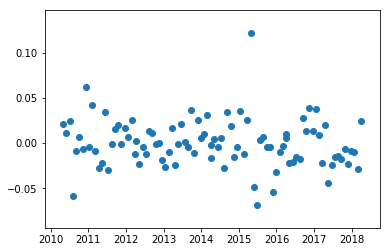

In [42]:
# regression.linear_model.RegressionResults
# results.resid_pearson
# results.model.data.endog
# results.model.data.exog
# results.resid.plot()
plt.scatter(results.resid.index,results.resid)

In [43]:
# import statsmodels.compat.lzip as lzip #No module named 'statsmodels.compat.lzip'
# 应该是lzip是compat的属性，而不是子模块，import 只能引入到模块级别，不能引入到属性活着功能级别
from statsmodels.compat import lzip
import statsmodels.iolib.table as table

def white_test(results):
    name = ['lm statistic', 'lm_pvalue','f-statistic',"f_pvalue"]
    # f-statistic of the hypothesis that the error variance does not depend on x. This is an alternative test variant not the original LM test.
    test = sms.het_white(results.resid, results.model.exog)
    ziped=lzip(name, test)
    # white=sms.het_white(results.resid,results.model.exog)
    white=table.SimpleTable(ziped)
    white.title="White Test"
#     print(white)
    return white
white_test(results)
#     print(white)
#             White Test            
# ==================================
# lm statistic   41.55454399712868  
#  lm_pvalue   3.963585550453876e-06
# f-statistic    7.343179599291278  
#   f_pvalue   7.650453944017435e-08
# ----------------------------------


# sms.het_white?

lm statistic,41.55454399712868
lm_pvalue,3.963585550453876e-06
f-statistic,7.343179599291278
f_pvalue,7.650453944017435e-08


In [44]:
#np.log(smb)#负数没有log，所以出现了问题，收益率不好用log来调整，都加1求log好像也不太好的方式，
# /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
#   """Entry point for launching an IPython kernel.
# /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
#   """Entry point for launching an IPython kernel.
# sms.linear_rainbow(results)#(0.835850366394606, 0.7279272220899624)

name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(results.resid, results.model.exog)
ziped=lzip(name, test)
bp=table.SimpleTable(ziped)
bp
# sms.het_breuschpagan?

Lagrange multiplier statistic,15.696774193847506
p-value,0.0013084045662245308
f-value,6.003986332711091
f p-value,0.0008857284997649453


In [45]:
# Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(results.model.endog, results.model.exog,idx=2)
ziped=lzip(name, test)
gq=table.SimpleTable(ziped)
gq
# sms.het_goldfeldquandt?

F statistic,0.5861564076464453
p-value,0.9589151204538203


In [46]:
# YT=get_y(return_data_ydyl,Rf)
# # YT=get_y(return_data["600000.XSHG"],Rf)
# X = sm.add_constant(X)
# mod = regression.linear_model.OLS(YT, X).fit()
# p = mod.params
# print(p)
# mod.summary()
# #HML	Rm_Rf	SMB	bigdata

In [47]:
#np.corrcoef(X)
# np.seterr(divide='ignore', invalid='ignore')
# np.corrcoef(X,rowvar=False)#终于调用成功了，原因时前面的X = sm.add_constant(X)改变了X，已经不是一个简单的3维数组啦，是4列了，而去第一列的数据是：1.00000000e+00所以报错了。
ols_model2=smf.ols('y ~ HML + SMB', data=df_xy)
results2 = ols_model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     330.6
Date:                Sat, 18 Aug 2018   Prob (F-statistic):           9.93e-43
Time:                        16:54:15   Log-Likelihood:                 205.86
No. Observations:                  95   AIC:                            -405.7
Df Residuals:                      92   BIC:                            -398.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0053      0.003     -1.649      0.103      -0.012       0.001
HML            0.7522      0.175      4.286      0.000       0.404       1.101
SMB           -0.9857      0.063    -15.768      0.000      -1.110      -0.862
==============================================================================
Omnibus:                       44.542   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.031
Skew:                           1.385   Prob(JB):                     9.08e-47
Kurtosis:                       9.774   Cond. No.                         62.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
name = ['lm statistic', 'lm_pvalue','f-statistic',"f_pvalue"]
# f-statistic of the hypothesis that the error variance does not depend on x. This is an alternative test variant not the original LM test.
test = sms.het_white(results2.resid, results2.model.exog)
ziped=lzip(name, test)
# white=sms.het_white(results.resid,results.model.exog)
white=table.SimpleTable(ziped)
white.title="White Test"
# results.model.exog
white

lm statistic,24.98353968246647
lm_pvalue,0.0001403571539449367
f-statistic,6.35146370340775
f_pvalue,4.355011039607862e-05


In [49]:
# price_data=get_price_cs(data_starttime,data_endtime)#1944 rows × 3631 columns
# price_data

In [50]:
import statsmodels.api as sm
# sm.formula==smf#True
# regression.linear_model.OLS??
# results.compare_lm_test(restricted={"model":{"ssr":results.ssr,"df_resid":results.df_resid}})

In [51]:
# ols_model.whiten(results.resid)
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind,levene
from statsmodels.stats import anova
from statsmodels.stats.anova import anova_lm
# pearsonr??
# results
# levene(df_X.iloc[:,0],df_X.iloc[:,1])
anova_lm(results,test="Chisq")

,df,sum_sq,mean_sq,Chisq,PR(>Chisq)
HML,1.0,0.327141,0.327141,0.0,0.0
SMB,1.0,0.197157,0.197157,0.0,0.0
bigdata,1.0,0.007566,0.007566,0.0,0.0
Residual,91.0,0.065387,0.000719,0.0,0.0


In [52]:
# anova_lm?

([array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 95.]),
  array([ 0.,  0., 90.,  5.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 0.,  9., 73., 13.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 1., 13., 43., 28.,  6.,  2.,  2.,  0.,  0.,  0.])],
 array([-0.36059057, -0.22453152, -0.08847246,  0.0475866 ,  0.18364566,
         0.31970471,  0.45576377,  0.59182283,  0.72788189,  0.86394094,
         1.        ]),
 <a list of 4 Lists of Patches objects>)

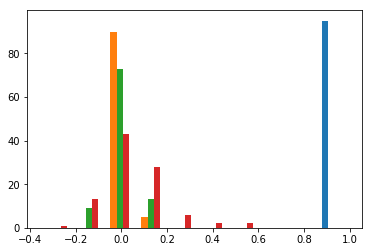

In [53]:
 plt.hist(results.model.exog)

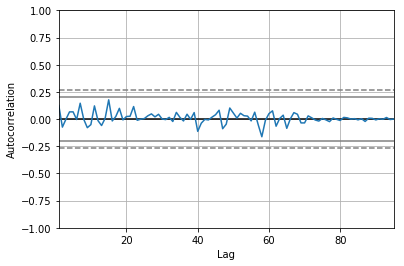

In [54]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_xy)
# autocorrelation_plot(results.resid)

In [55]:
# fig = plt.figure(figsize=(15,8))
# fig = sm.graphics.plot_regress_exog(results, df_X.columns, fig=fig)
# df_X[:,np.array([True,False,True])]
# np.array(df_X)==np.asarray(df_X)

# 大数据因子的各种处理
# df_bigdata_origin=pd.read_csv("bigdata.csv",encoding="gbk",index_col=0)
# df_bigdata_origin
# df_bigdata=pd.Series(df_bigdata_origin["收盘点位"],index=df_bigdata_origin.index,name="bigdata")
# # df_bigdata["close"]=df_bigdata_origin["收盘点位"]
# df_bigdata.index.name="index_date"
# df_bigdata.to_csv("bigdata_close.csv")
# df_bigdata=trans_index(df_bigdata)
# df_bigdata2=df_bigdata[df_bigdata.index.isin(index_date)]
# df_bigdata2.to_csv("bigdata_pure.csv")
# df_bigdata=pd.read_csv("bigdata_pure.csv",index_col=0,header=None)
# df_bigdata["test"]=df_bigdata_origin["收盘点位"]
# df_bigdata

In [56]:
# dfx=df_X.copy()
# dfx["y"]=return_data_ydyl-Rf
# dfx["seq"]=np.arange(len(dfx))
# dfx.index.name="date"
# # dfx.reindex(index=["seq","date"],columns=["HML","Rm_Rf","SMB","bigdata"],copy=True)
# # dfx.index.append(dfx["seq"])
# df=pd.DataFrame(dfx[["HML","Rm_Rf","SMB","bigdata"]].values,index=[dfx["seq"],dfx.index],columns=["HML","Rm_Rf","SMB","bigdata"])
# df

In [57]:
# price_data.apply(lambda x:x)
# np.percentile([1,2,np.nan,4,5],40)
# price_data.dropna(axis=1,how='all') 
# fm  = pd.fama_macbeth(y=df['y'],x=df[["HML","Rm_Rf","SMB","bigdata"]])
# fm

In [58]:
# df = pd.DataFrame({
#         'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
#         'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
#         'C': np.random.randn(8),
#         'D': np.random.randn(8)
#     })
def fmreg(data,formula):
    return smf.ols(formula,data=data).fit().params

res=df_xy.groupby('date').apply(fmreg,'ret~var1+var2+var3')

KeyError: 'date'

In [ ]:
# df.groupby("A").mean()
# ss=pd.Series([3,3,3,np.nan,44])
# type(ss.value_counts(dropna=1))
# type(pd.pivot_table(df, values='D', index=['A', 'B'], columns=['C']))#pd.pivot_table(df, values='D', index=['A', 'B'], columns=['C'])

In [ ]:
# ?smf.wls()
ols_model3=smf.wls('y ~ HML + SMB + bigdata', data=df_xy)
results3 = ols_model3.fit()#cov_type='HC3'
results3.summary()

In [ ]:
white_test(results3)

In [8]:
import time
time.time()
time.strftime()

1534677163.808129